In [92]:
from Gaugi.monet.TAxisFunctions import *
from Gaugi.monet.PlotFunctions import *
from Gaugi.monet import ATLASLabel
from Gaugi.monet.utils import NormHist, getColor
from ROOT import TH1F,TCanvas, TFile, TPad, TColor
from ROOT import kBlack,kBlue,kRed,kAzure,kGreen,kMagenta,kCyan,kOrange,kGray,kYellow
import numpy as np
import array
import os
from pprint import pprint
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
from Gaugi.monet.AtlasStyle import SetAtlasStyle
SetAtlasStyle()


Applying ATLAS style settings...


In [94]:
etbins = [15, 20, 30, 40, 50, 1000000]
etabins = [0.0, 0.8, 1.37, 1.54, 2.37, 2.50]

In [95]:
def get_models( location , etbins, etabins, remove_last=True):
    from tensorflow.keras.models import Model, model_from_json
    from tensorflow.keras.layers import Activation
    import json
    models = [[ None for _ in range(len(etabins)-1)] for __ in range(len(etbins)-1)]
    for et_bin in range(len(etbins)-1):
        for eta_bin in range(len(etabins)-1):
            d_tuned = {}
            path=location.format(ET=et_bin,ETA=3 if eta_bin==4 else eta_bin)
            #print(path)
            with open(path+'.json', 'r') as json_file:
                model = model_from_json(json_file.read())
                # load weights into new model
                model.load_weights(path+".h5")
                # since the production version has no tansig fucntion as default. Let's include it
                # for study
                model.add(Activation('tanh'))
                new_model = Model(model.inputs, model.layers[-2].output) if remove_last else model
                d_tuned['model']    = new_model
                d_tuned['etBin']    = [etbins[et_bin], etbins[et_bin+1]]
                d_tuned['etaBin']   = [etabins[eta_bin], etabins[eta_bin+1]]
                d_tuned['etBinIdx'] = et_bin
                d_tuned['etaBinIdx']= eta_bin
                models[et_bin][eta_bin] = d_tuned
                
    # return the models's matrix          
    return models

model_path = '/Volumes/castor/tuning_data/Zee/production/TrigL2_20170505_v6/models'
model_path+='/mc15_13TeV.423300.Zee_probes_lhmedium.423300.JF17_Truth.model_v6.electronTight.et{ET}_eta{ETA}'
best_models = get_models(model_path, etbins, etabins,remove_last=True)

In [96]:
path = '/Volumes/castor/cern_data/files/Zee/mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17/'
path+= 'mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17_et{ET}_eta{ETA}.npz'
mc_paths = [[ path.format(ET=et,ETA=eta) for eta in range(5)] for et in range(5)] 

In [97]:
path = '/Volumes/castor/cern_data/files/Zee/data16_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.GRL_v97.mc15_13TeV.bkg.Truth.JF17/'
path+= 'data16_13TeV.AllPeriods.sgn.probes_lhmedium.GRL_v97.mc15_13TeV.bkg.Truth.JF17_et{ET}_eta{ETA}.npz'
data_paths = [[ path.format(ET=et,ETA=eta) for eta in range(5)] for et in range(5)]

## Generate NN plot:

In [98]:
def get_nn_output( _path, _model ):
    from Gaugi import load
    def norm1( data ):
        norms = np.abs( data.sum(axis=1) )
        norms[norms==0] = 1
        return data/norms[:,None]
    from Gaugi import load
    d = load(_path)
    # extract rings
    data_rings = norm1(d['data'][:,1:101])
    target = d['target']
    output = _model.predict(data_rings,batch_size=1024, verbose=1).flatten()
    return output, target

In [99]:
mc_outputs , mc_target= get_nn_output(mc_paths[2][0], best_models[2][0]['model'])
mc_outputs.shape

120/120 [==============================] - 0s 1ms/step


(121879,)

In [100]:
data_outputs , data_target = get_nn_output(data_paths[2][0], best_models[2][0]['model'])
data_outputs.shape

1155/1155 [==============================] - 1s 1ms/step


(1182602,)

In [101]:
def AddLegend(canvas, x, y, legends):
    MakeLegend( canvas,x,y,x+0.48,y+0.20,textsize=16, names=legends, option = 'f' )

In [103]:
def plot_mc_versus_data( _mc_outputs, _data_outputs , xbins, xmin, xmax , 
                          these_color_fill, these_color_line, normalize=False, y_maximum=None, 
                          xlabel = 'Neural Network Output (Discriminant)',
                          ylabel = 'counts/bin (norm by counts)',
                          bot_label = 'Data/MC'):
    
    mc = TH1F( 'mc', '', xbins, xmin, xmax )
    w = array.array( 'd', np.ones_like( _mc_outputs ) )
    mc.FillN( len(_mc_outputs), array.array('d',  _mc_outputs.tolist()), w)  
    pp = TH1F( 'data', '', xbins, xmin, xmax )
    w = array.array( 'd', np.ones_like( _data_outputs ) )
    pp.FillN( len(_data_outputs), array.array('d',  _data_outputs.tolist()), w)
    
    canvas = TCanvas('canvas',"",700, 500)
    if normalize:
        mc = NormHist(mc)
        pp = NormHist(pp)
    mc.SetLineColor(these_color_line[0])
    mc.SetFillColor(these_color_fill[0])
    if y_maximum:
        mc.SetMaximum(y_maximum)
    pp.SetLineColor(these_color_line[1])
    pp.SetFillColor(these_color_fill[1])
    if y_maximum:
        pp.SetMaximum(y_maximum)
    AddHistogram(canvas,mc, 'same')
    AddHistogram(canvas,pp, 'same')    
    FormatCanvasAxes(canvas, XLabelSize=16, YLabelSize=16, XTitleOffset=0.87, ZLabelSize=16,
                             ZTitleSize=16, YTitleOffset=1.20, ZTitleOffset=1.1)
    SetAxisLabels(canvas,xlabel, ylabel, bot_label)
    return canvas

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file nn_output_mc15_versus_data16_et2_eta0.pdf has been created


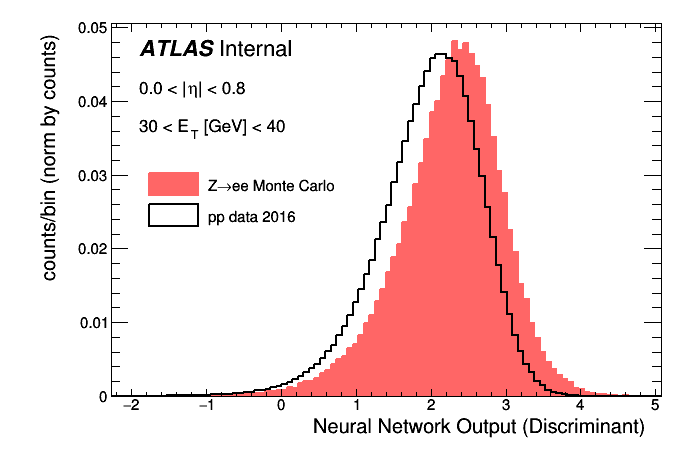

In [123]:
color_fill = [kAzure-4,0]
color_line = [kRed-7, kBlack]
color_fill = [kRed-7,0]

canvas = plot_mc_versus_data(mc_outputs[mc_target==1], data_outputs[data_target==1], 
                             100, -2.2, 5.0, color_fill, color_line, normalize=True)

AddATLASLabel(canvas, 0.2, 0.88, 'Internal')
AddTexLabel(canvas, 0.2, 0.80, '0.0 < |#eta| < 0.8', textsize=0.04)
AddTexLabel(canvas, 0.2, 0.72, '30 < E_{T} [GeV] < 40', textsize=0.04)
AddLegend( canvas,0.2,0.51, ['Z#rightarrowee Monte Carlo', 'pp data 2016'])
canvas.Draw()
canvas.SaveAs("nn_output_mc15_versus_data16_et2_eta0.pdf")

## Generate Shower shapes plot:

In [115]:
def get_shower_shape( _path, name ):
    from Gaugi import load
    d = load(_path)
    features = d['features'].tolist()
    # extract rings
    data = d['data'][:,features.index(name)]
    target = d['target']
    return data, target

In [116]:
mc_reta, mc_target = get_shower_shape(mc_paths[2][0], 'L2Calo_reta' )
data_reta, data_target = get_shower_shape(data_paths[2][0], 'L2Calo_reta' )

In [117]:
mc_eratio, _ = get_shower_shape(mc_paths[2][0], 'L2Calo_eratio' )
data_eratio, _ = get_shower_shape(data_paths[2][0], 'L2Calo_eratio' )

In [118]:
mc_weta2, _ = get_shower_shape(mc_paths[2][0], 'L2Calo_weta2' )
data_weta2, _ = get_shower_shape(data_paths[2][0], 'L2Calo_weta2' )

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file L2Calo_reta_mc15_versus_data16_et2_eta0.pdf has been created


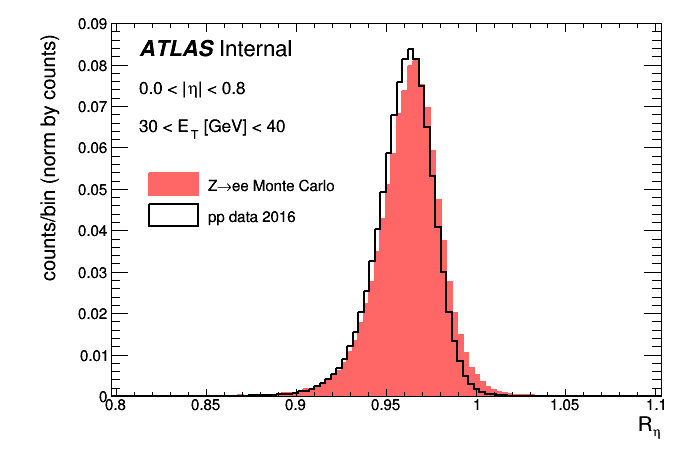

In [130]:
#color_fill = [kAzure-4,0]
#color_line = [kBlue, kBlack]
canvas = plot_mc_versus_data(mc_reta[mc_target==1], data_reta[data_target==1], 
                             100, 0.8, 1.1, color_fill, color_line, normalize=True,
                            xlabel='R_{#eta}', y_maximum=0.09)

AddATLASLabel(canvas, 0.2, 0.88, 'Internal')
AddTexLabel(canvas, 0.2, 0.80, '0.0 < |#eta| < 0.8', textsize=0.04)
AddTexLabel(canvas, 0.2, 0.72, '30 < E_{T} [GeV] < 40', textsize=0.04)
AddLegend( canvas,0.2,0.51, ['Z#rightarrowee Monte Carlo', 'pp data 2016'])
canvas.Draw()
canvas.SaveAs("L2Calo_reta_mc15_versus_data16_et2_eta0.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file L2Calo_weta2_mc15_versus_data16_et2_eta0.pdf has been created


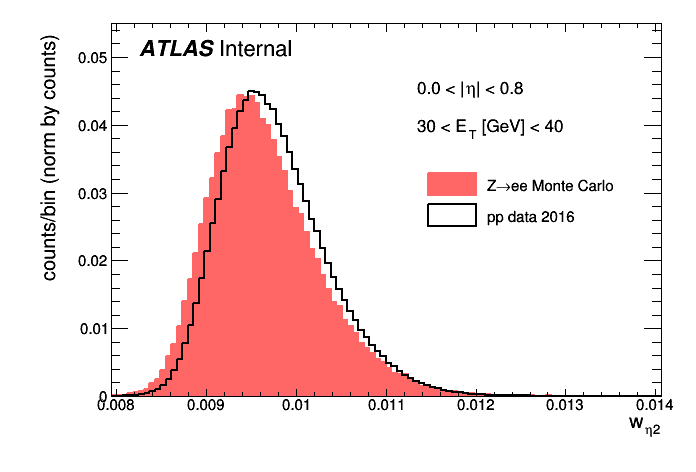

In [125]:
#color_fill = [kAzure-4,0]
#color_line = [kBlue, kBlack]
canvas = plot_mc_versus_data(mc_weta2[mc_target==1], data_weta2[data_target==1], 
                             100, 0.008, 0.014, color_fill, color_line, normalize=True, y_maximum=0.055,
                             xlabel='w_{#eta2}')

AddATLASLabel(canvas, 0.2, 0.88, 'Internal')
AddTexLabel(canvas, 0.6, 0.80, '0.0 < |#eta| < 0.8', textsize=0.04)
AddTexLabel(canvas, 0.6, 0.72, '30 < E_{T} [GeV] < 40', textsize=0.04)
AddLegend( canvas,0.6,0.51, ['Z#rightarrowee Monte Carlo', 'pp data 2016'])
canvas.Draw()
canvas.SaveAs("L2Calo_weta2_mc15_versus_data16_et2_eta0.pdf")

In [121]:
mc_ring9, _ = get_shower_shape(mc_paths[2][0], 'L2Calo_ring_8' )
data_ring9, _ = get_shower_shape(data_paths[2][0], 'L2Calo_ring_8' )

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file L2Calo_ring9_mc15_versus_data16_et2_eta0.pdf has been created


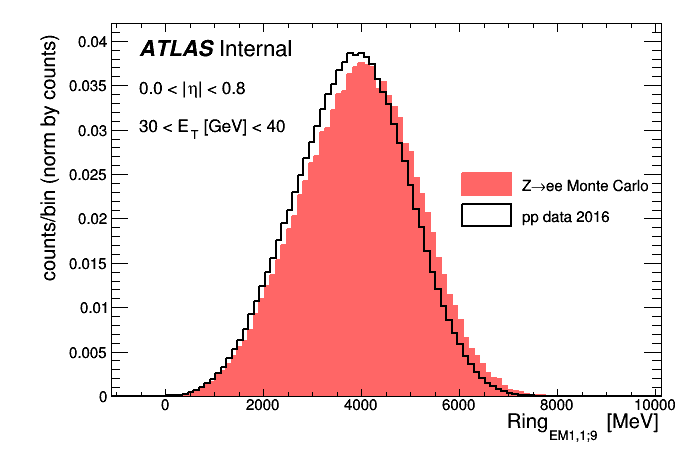

In [129]:
#color_fill = [kAzure-4,0]
#color_line = [kBlue, kBlack]
canvas = plot_mc_versus_data(mc_ring9[mc_target==1], data_ring9[data_target==1], 
                             100, -1000, 10000, color_fill, color_line, normalize=True,
                            xlabel='Ring_{EM1,1;9} [MeV]', y_maximum=0.042)

AddATLASLabel(canvas, 0.2, 0.88, 'Internal')
AddTexLabel(canvas, 0.2, 0.80, '0.0 < |#eta| < 0.8', textsize=0.04)
AddTexLabel(canvas, 0.2, 0.72, '30 < E_{T} [GeV] < 40', textsize=0.04)
AddLegend( canvas,0.65,0.51, ['Z#rightarrowee Monte Carlo', 'pp data 2016'])
canvas.Draw()
canvas.SaveAs("L2Calo_ring9_mc15_versus_data16_et2_eta0.pdf")